# 0. 环境准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 设置pandas可以显示的行数和列数
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# 忽略warnings
import warnings
warnings.filterwarnings("ignore")

#推荐安装插件： nbextensions

# 1.读入数据

In [2]:
# date: 日期
# company: 公司代码
# price: 股价
df_stock = pd.read_csv('data/stock_price.csv', parse_dates=['date'])
df_stock.head(2)

,date,company,price
0,2012-05-18,FB,38.230000
1,2012-05-21,FB,34.029999


# 2. 用移动平均法做股价预测

## 以FB的股票数据为例，站在2022-01-01，预测接下来1天的股价

In [3]:
N = 10 #用过去10天的平均值作为对未来的预测

his_date_end = pd.to_datetime('2022-01-01')
his_date_begin = his_date_end - pd.Timedelta(N-1, unit='D')
pred_price = df_stock[ (df_stock['company']=='FB') & 
                  (df_stock['date']>=his_date_begin) & 
                  (df_stock['date']<=his_date_end)]['price'].mean()

## 以FB的股票数据为例，站在2022-01-01，预测接下来h天的股价

In [4]:
N = 10 #用过去10天的平均值作为对未来的预测
h = 4 #预测未来4天的股价

his_date_end = pd.to_datetime('2022-01-01')
his_date_begin = his_date_end - pd.Timedelta(N-1, unit='D')
pred_price = df_stock[ (df_stock['company']=='FB') & 
                  (df_stock['date']>=his_date_begin) & 
                  (df_stock['date']<=his_date_end)]['price'].mean()

target_begin = his_date_end + pd.Timedelta(1, unit='D')
target_end = his_date_end + pd.Timedelta( h,unit='D' )
pred_result=  pd.DataFrame({'date':pd.date_range(target_begin, target_end, freq='D'),
                           'pred_price':[pred_price]*h})

# 用ETS算法做股价预测

In [5]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

## 以FB的股票数据为例，站在2022-01-01，预测接下来h天的股价

In [6]:
# 构建训练集
his_date_end = pd.to_datetime('2022-01-01')
data_train = df_stock[ (df_stock['company']=='FB') & 
                     (df_stock['date']<=his_date_end)]

# 把日期变成训练集的index
data_train = data_train[['date','price']].set_index('date')

In [7]:
# 构建模型
model = ETSModel( data_train['price'] )
fit = model.fit( )

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


(array([18635., 18642., 18649., 18659., 18666., 18673., 18680., 18687.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

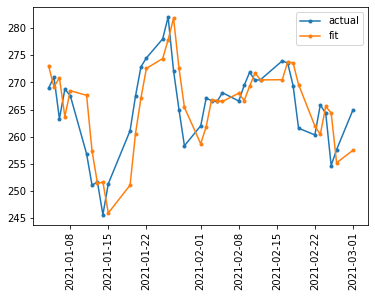

In [8]:
# 模型拟合结果可视化
data_train['fit_price'] = fit.fittedvalues
data_plot = data_train[ (data_train.index>='2021-01-01') & 
                      (data_train.index<='2021-03-01')]
plt.plot( data_plot['price'], '.-',label='actual' )
plt.plot( data_plot['fit_price'],'.-', label='fit' )
plt.legend()
plt.xticks(rotation=90)

In [9]:
# 预测未来h天
h = 10
pred_price = fit.get_prediction(start=data_train.shape[0]+1,
                               end = data_train.shape[0]+h)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No sup

In [10]:
pred_price.summary_frame()[['mean']]

,mean
2423,336.763053
2424,336.763053
2425,336.763053
2426,336.763053
2427,336.763053
2428,336.763053
2429,336.763053
2430,336.763053
2431,336.763053
2432,336.763053


# 时间序列平稳性

ACF检验 (Auto-Correlation Function, 自相关系数检验） 
$$ r_h = Cor( X_t, X_{t+h} ) , \forall t$$
如果每隔h个单位，ACF值有一个局部高峰，则数据存在以h为单位的周期性

## 检验FB股票数据的平稳性

In [11]:
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = df_stock[ (df_stock['company']=='FB')].sort_values('date')

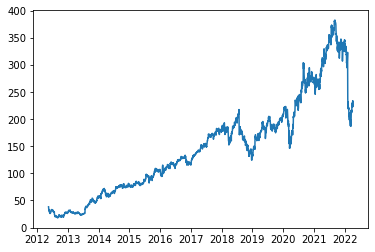

In [12]:
plt.plot( df['date'], df['price'] )

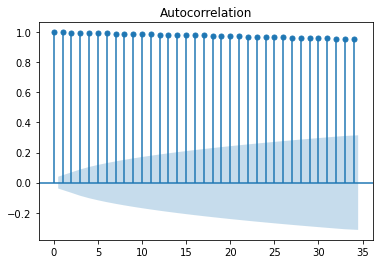

In [13]:
plot_acf(df['price']).show()

自相关性系数大，说明时间序列不平稳

## 通过差分的方式，获取平稳的时间序列

差分的定义： $$ y^1_t = y_t - y_{t-1} $$

In [14]:
df['price_last'] = df['price'].shift(1)
df['price_diff'] = df['price'] -df['price_last']

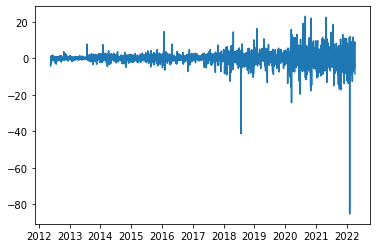

In [15]:
plt.plot( df['date'], df['price_diff'] )

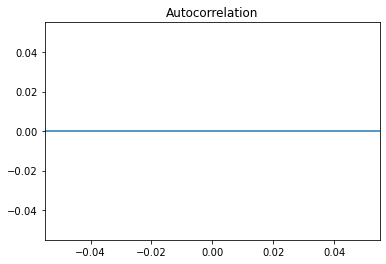

In [16]:
plot_acf(df['price_diff']).show()

# 使用Arima做预测

 ## 以FB的股票数据为例，站在2022-01-01，预测接下来h天的股价

In [17]:
# 构建训练集
his_date_end = pd.to_datetime('2022-01-01')
data_train = df_stock[ (df_stock['company']=='FB') & 
                     (df_stock['date']<=his_date_end)].sort_values('date')

In [18]:
# 通过ACF判断确定I阶数d， 要求是d阶差分是平稳的
d = 1

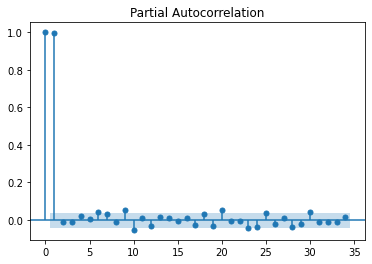

In [19]:
# AR的阶数p可以通过pacf （偏相关性系数） 图来设定，因为AR各项的系数就代表每两个时间间隔的相关性
# 要求p以后的偏相关性系数比较小
from  statsmodels.graphics.tsaplots import plot_pacf
plot_pacf( data_train['price'] ).show()

In [20]:
p = 1

In [21]:
# 通过差分的ACF判断确定MA阶数q， 要求是q以后的自相关性系数比较小
q = 0 

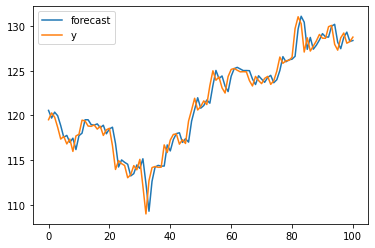

In [22]:
# 构建Arima模型
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data_train['price'].values, order=(p,d,q))
fit = model.fit()

# 模型拟合结果可视化
fit.plot_predict(start=1000, end = 1100, dynamic=False).show()

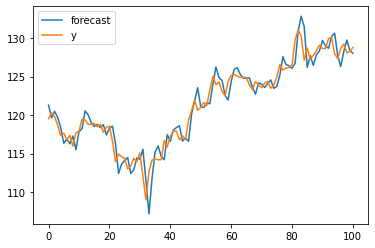

In [23]:
## 换一组参数可以让模型的结果更复杂

model = ARIMA(data_train['price'].values, order=(2,2,0))
fit = model.fit()

# 模型拟合结果可视化
fit.plot_predict(start=1000, end = 1100, dynamic=False).show()

In [24]:
# 模型预测
h = 10
fit.forecast(h)[0]

array([333.47033105, 329.8134213 , 325.18798593, 321.45814749,
       317.39325686, 313.29622802, 309.31879503, 305.26740753,
       301.23117802, 297.20534408])

另外， 大家还可以通过auto arima自动调整p, d, q
https://pypi.org/project/pmdarima/
